In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture
import json, os
if not os.path.exists(".kaggle"):
  !mkdir .kaggle
token = {"username":"fndloyolacz","key":"f5b04e39a978b3f0ba2ad97be902754e"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
if not os.path.exists("train.csv.zip"):
  !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge --force
  !kaggle datasets download -d terenceliu4444/glove6b100dtxt --force
  #!kaggle datasets download -d watts2/glove6b50dtxt --force
  !unzip \*.zip

In [ ]:
%%capture
import nltk
from nltk.corpus import stopwords
import keras
import torch
import tensorflow
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

%matplotlib inline
plt.style.use('bmh')

nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(['im','zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

pd.set_option('display.max_colwidth', -1)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
train = pd.read_csv("train.csv")
#train.head()

In [ ]:
test_comments = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
test = pd.merge(test_comments, test_labels, on='id')
test = test[test.toxic >= 0]
#test.head()

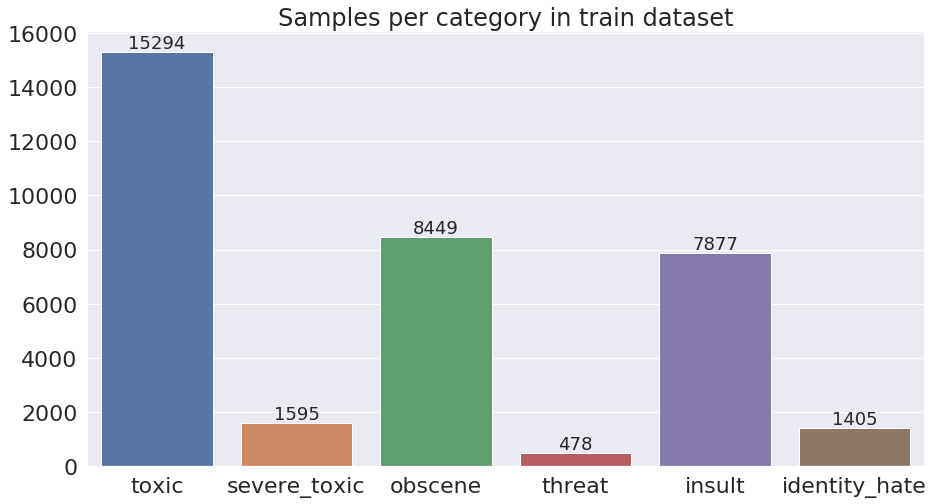

In [ ]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(classes, train.iloc[:,2:].sum().values)

plt.title("Samples per category in train dataset", fontsize=24)

#adding the text labels
rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

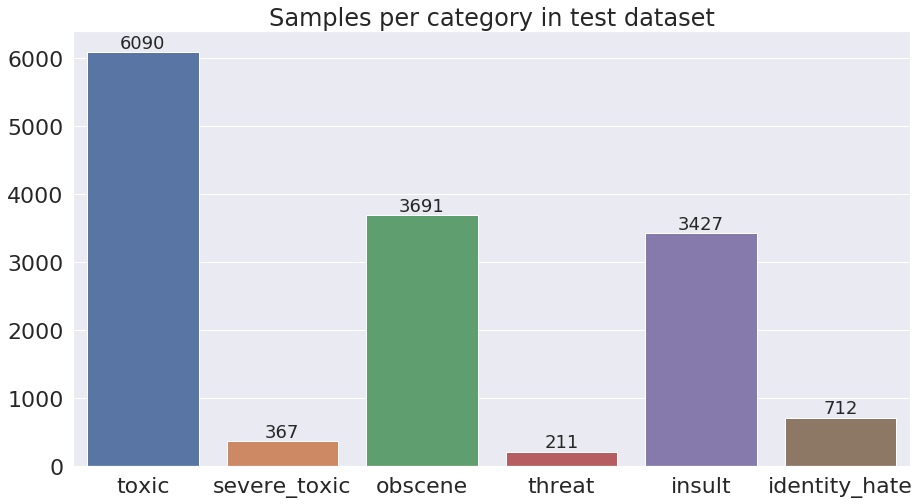

In [ ]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(classes, test.iloc[:,2:].sum().values)

plt.title("Samples per category in test dataset", fontsize=24)

#adding the text labels
rects = ax.patches
labels = test.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

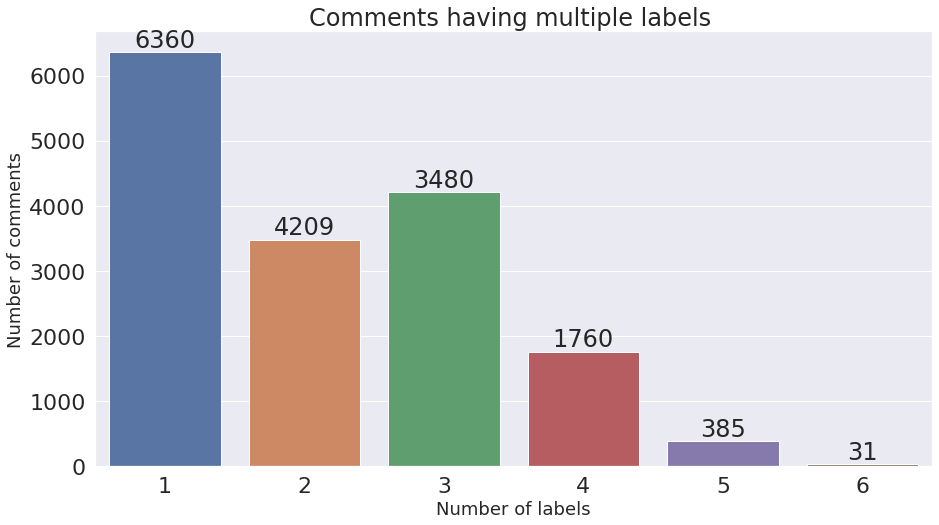

In [ ]:
rowSums = train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
def lemmatize(text):
    sentence = ""
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for word in text.split():
      if word not in stop_words:
        lemma = lemmatizer.lemmatize(word, pos="v")
        sentence += lemma
        sentence += " "
    sentence = sentence.strip()
    return sentence


def normalize(text):
  sentence = text.lower()
  sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE)) # Remove whitespaces
  sentence = re.sub(r'[^\w\s]','',sentence) # Remove punctuation
  sentence = re.sub(r'\d+', '', sentence)  #Remove number
  return sentence


def preprocess(text):
  sentence = normalize(text)
  sentence = lemmatize(sentence)
  return sentence

In [ ]:
train['text_lemmatized'] = train.comment_text.apply(preprocess)
test['text_lemmatized'] = test.comment_text.apply(preprocess)
columns = ['comment_text', 'text_lemmatized', "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
train = train[columns]
test = test[columns]
#train.head()

In [ ]:
def most_used(category, samples, data):
  from collections import Counter 

  subset = data[ data[category] ==1 ]
  all_values = str(subset.text_lemmatized.values)

  split_it = all_values.split() 
  
  Counter = Counter(split_it) 
  
  most_occur = Counter.most_common(samples) 
  most_occur.sort(reverse=True,  key=lambda obj: obj[1]) 
  
  print(f"{category} : {most_occur}")

In [ ]:
for label in classes:
  most_used(label, 20, train)

toxic : [('delete', 6), ('dont', 5), ('stop', 5), ('edit', 4), ('bullshit', 3), ('ever', 3), ('ass', 3), ('get', 3), ("'hey", 2), ('wp', 2), ('ask', 2), ('fuck', 2), ('like', 2), ('wwe', 2), ('k', 2), ('roster', 2), ('confirm', 2), ('stupid', 2), ('please', 2), ('shit', 2)]
severe_toxic : [('fuck', 5), ('go', 3), ('die', 3), ('jew', 3), ('piss', 2), ("'stupid", 2), ('shit', 2), ('youre', 2), ('dont', 2), ('get', 2), ("['cocksucker", 1), ('around', 1), ("work'", 1), ('peace', 1), ('stop', 1), ('delete', 1), ('stuff', 1), ('asshole', 1), ('fall', 1), ('hole', 1)]
obscene : [('fuck', 23), ('go', 5), ('shit', 5), ('like', 5), ('say', 4), ('edit', 4), ('ass', 3), ('little', 3), ('take', 3), ('bitch', 3), ('ever', 3), ('bullshit', 3), ('white', 2), ('make', 2), ('gay', 2), ('last', 2), ('nazi', 2), ('dont', 2), ('mother', 2), ('sorry', 2)]
threat : [('die', 1142), ('ass', 759), ('kill', 486), ('go', 343), ('fuck', 237), ('block', 181), ('must', 163), ('wales', 157), ('jim', 157), ('supertrll

In [ ]:
for label in classes:
  most_used(label, 20, test)

toxic : [('supposedly', 6), ('make', 5), ('iran', 5), ('miles', 4), ('right', 3), ('use', 3), ('say', 3), ('incident', 3), ('article', 3), ('europe', 2), ('possibly', 2), ('drone', 2), ('word', 2), ('airspace', 2), ('like', 2), ('consider', 2), ('wing', 2), ('happen', 2), ('sense', 2), ('occur', 2)]
severe_toxic : [('fuck', 2198), ('bitch', 943), ('nigger', 752), ('die', 605), ('suck', 553), ('shit', 550), ('ass', 497), ('like', 427), ('niggerjew', 423), ('must', 407), ('traitor', 405), ('vandal', 405), ('diefuk', 402), ('niggers', 395), ('fag', 348), ('cunt', 319), ('mother', 296), ('motherfuckerdie', 287), ('faggot', 278), ('gay', 277)]
obscene : [('supposedly', 6), ('iran', 5), ('miles', 4), ('make', 4), ('like', 3), ('right', 3), ('use', 3), ('say', 3), ('incident', 3), ('article', 3), ('get', 2), ('bitch', 2), ('drone', 2), ('word', 2), ('airspace', 2), ('consider', 2), ('wing', 2), ('happen', 2), ('sense', 2), ('occur', 2)]
threat : [('must', 323), ('traitor', 313), ('vandal', 31

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, SpatialDropout1D
from keras.models import Model
from tensorflow.keras.models import load_model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
##### CONS

trainable = False
epochs = 20
batch_size = 32

In [ ]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

list_sentences_train = train["text_lemmatized"].fillna("_na_").values
list_sentences_test = test["text_lemmatized"].fillna("_na_").values

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

X_train = pad_sequences(list_tokenized_train, maxlen=maxlen, padding="post")
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen, padding="post")

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open("glove.6B.100d.txt"))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
nn = Sequential()
embedding_layer = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable)
nn.add(embedding_layer)

nn.add(Flatten())
nn.add(Dense(6, activation='sigmoid'))
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history_nn = nn.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)

score = nn.evaluate(X_test, test[classes].values, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Train on 135635 samples, validate on 23936 samples
Epoch 1/20
135635/135635 [==============================] - 23s 168us/step - loss: 0.0988 - acc: 0.9702 - val_loss: 0.0922 - val_acc: 0.9726
Epoch 2/20
135635/135635 [==============================] - 20s 145us/step - loss: 0.0858 - acc: 0.9731 - val_loss: 0.1004 - val_acc: 0.9725
Epoch 3/20
135635/135635 [==============================] - 18s 136us/step - loss: 0.0816 - acc: 0.9741 - val_loss: 0.0978 - val_acc: 0.9718
Epoch 4/20
135635/135635 [==============================] - 19s 139us/step - loss: 0.0782 - acc: 0.9749 - val_loss: 0.0952 - val_acc: 0.9718
Epoch 5/20
135635/135635 [==============================] - 18s 134us/step - loss: 0.0780 - acc: 0.9749 - val_loss: 0.0922 - val_acc: 0.9732
Epoch 6/20
135635/135635 [==============================] - 18s 135us/step - loss: 0.0764 - acc: 0.9756 - val_loss: 0.0957 - val_acc: 0.9721
Epoch 7/20
135635/135635 [==============================] - 18s 135us/step - loss: 0.0749 - acc: 0.9758

KeyboardInterrupt: ignored

In [ ]:
nn.save(f'/content/gdrive/My Drive/Colab Notebooks/nn_{score[1].round(3)}.h5')
#nn = load_model("/content/gdrive/My Drive/Colab Notebooks/nn.h5")

In [ ]:
model3 = Sequential()
model3.add(Embedding(max_features, embed_size, input_length=maxlen))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=28))
model3.add(LSTM(100))
model3.add(Dense(6, activation="softmax"))
model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_model3 = model3.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = model3.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

model3.save(f'/content/gdrive/My Drive/Colab Notebooks/model3_{score[1].round(3)}.h5')
#model = load_model("/content/gdrive/My Drive/Colab Notebooks/model3.h5")

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dense(6, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_model = model.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = model.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

model.save(f'/content/gdrive/My Drive/Colab Notebooks/model_{score[1].round(3)}.h5')
#model = load_model("/content/gdrive/My Drive/Colab Notebooks/model.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/20
135635/135635 [==============================] - 187s 1ms/step - loss: 0.3004 - acc: 0.9917 - val_loss: 0.2918 - val_acc: 0.9935
Epoch 2/20
135635/135635 [==============================] - 180s 1ms/step - loss: 0.2916 - acc: 0.9854 - val_loss: 0.2870 - val_acc: 0.9825
Epoch 3/20
135635/135635 [==============================] - 180s 1ms/step - loss: 0.2848 - acc: 0.9813 - val_loss: 0.2820 - val_acc: 0.9934
Epoch 4/20
135635/135635 [==============================] - 177s 1ms/step - loss: 0.2782 - acc: 0.9793 - val_loss: 0.2802 - val_acc: 0.9657
Epoch 5/20
135635/135635 [==============================] - 177s 1ms/step - loss: 0.2723 - acc: 0.9767 - val_loss: 0.2801 - val_acc: 0.9789
Epoch 6/20
135635/135635 [==============================] - 176s 1ms/step - loss: 0.2671 - acc: 0.9757 - val_loss: 0.2805 - val_acc: 0.9703
Epoch 7/20
135635/135635 [==============================] - 176s 1ms/step - loss: 0.2633 - acc: 0.9740 - val_

In [ ]:
model2 = Sequential()
model2.add(Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable))
model2.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=4))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dense(6, activation="softmax"))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_model2 = model2.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = model2.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

model2.save(f'/content/gdrive/My Drive/Colab Notebooks/model2_{score[1].round(3)}.h5')
#model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model2.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/1
63978/63978 [==============================] - 30s 464us/step
Test Score: 0.28739918533958
Test Accuracy: 0.9635968614211136


In [ ]:
cnn = Sequential()

embedding_layer = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(6, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_cnn = cnn.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = cnn.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

cnn.save(f'/content/gdrive/My Drive/Colab Notebooks/cnn_{score[1].round(3)}.h5')
#nn = load_model("/content/gdrive/My Drive/Colab Notebooks/cnn.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/1
63978/63978 [==============================] - 19s 301us/step
Test Score: 0.07312966484229776
Test Accuracy: 0.971922630177661


In [ ]:
rnn = Sequential()
embedding_layer = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable)
rnn.add(embedding_layer)
rnn.add(LSTM(128))

rnn.add(Dense(6, activation='sigmoid'))
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history_rnn = rnn.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = rnn.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

rnn.save(f'/content/gdrive/My Drive/Colab Notebooks/rnn.h5_{score[1].round(3)}')
#rnn = load_model("/content/gdrive/My Drive/Colab Notebooks/rnn.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/1
63978/63978 [==============================] - 61s 949us/step
Test Score: 0.08254490260177691
Test Accuracy: 0.9671918375065255


In [ ]:
blstm = Sequential()
blstm.add(Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable))
blstm.add(Bidirectional(LSTM(64)))
blstm.add(Dropout(0.5))
blstm.add(Dense(6, activation='sigmoid'))
blstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_blstm = blstm.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = blstm.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

blstm.save(f'/content/gdrive/My Drive/Colab Notebooks/blstm_{score[1].round(3)}.h5')
#blstm = load_model("/content/gdrive/My Drive/Colab Notebooks/blstm.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/1
63978/63978 [==============================] - 62s 971us/step
Test Score: 0.07533385509056717
Test Accuracy: 0.970427323244434


In [ ]:
v2 = Sequential()
v2.add(Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable))
v2.add(Dropout(0.25))
v2.add(Conv1D(64,
                 5,
                 padding='valid',
                 activation='relu',
                 strides=1))
v2.add(MaxPooling1D(pool_size=4))
v2.add(LSTM(70))
v2.add(Dense(6))
v2.add(Activation('sigmoid'))

v2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_v2 = v2.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = v2.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

v2.save(f'/content/gdrive/My Drive/Colab Notebooks/v2_{score[1].round(3)}.h5')
#v2 = load_model("/content/gdrive/My Drive/Colab Notebooks/v2.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/1
63978/63978 [==============================] - 22s 352us/step
Test Score: 0.07972354870308779
Test Accuracy: 0.9718314553641987


In [ ]:
v3 = Sequential()
v3.add(Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=maxlen , trainable=trainable))
v3.add(Dropout(0.25))
v3.add(Conv1D(64,
                 5,
                 padding='valid',
                 activation='relu',
                 strides=1))
v3.add(MaxPooling1D(pool_size=4))
v3.add(Bidirectional(LSTM(70)))
v3.add(Dense(6))
v3.add(Activation('sigmoid'))

v3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_v3 = v3.fit(X_train, train[classes].values, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.15)
score = v3.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

v3.save(f'/content/gdrive/My Drive/Colab Notebooks/v3_{score[1].round(3)}.h5')
#v3 = load_model("/content/gdrive/My Drive/Colab Notebooks/v3.h5")

Train on 135635 samples, validate on 23936 samples
Epoch 1/1
63978/63978 [==============================] - 31s 483us/step
Test Score: 0.07922266362027484
Test Accuracy: 0.9693045414579661


In [ ]:
instance = "RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;"

instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

instance = pad_sequences(flat_list, maxlen=maxlen)
print ("#####INSULT####")
print(nn.predict(instance))
print(cnn.predict(instance))
print(rnn.predict(instance))
print(blstm.predict(instance))
print(v2.predict(instance))
print(v3.predict(instance))
print(model.predict(instance))
print(model2.predict(instance))
print(model3.predict(instance))


instance = "@JAYten9: In every cartoon theirs alway a @_nuffsaid15 saving these hoes lmao. http://t.co/9uKD8wtZ6x lmao damn captain SaveAHoe"

instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, maxlen=maxlen)

print ("\n#####NORMAL COMMENT####\n")
print(nn.predict(instance))
print(cnn.predict(instance))
print(rnn.predict(instance))
print(blstm.predict(instance))
print(v2.predict(instance))
print(v3.predict(instance))
print(model.predict(instance))
print(model2.predict(instance))
print(model3.predict(instance))


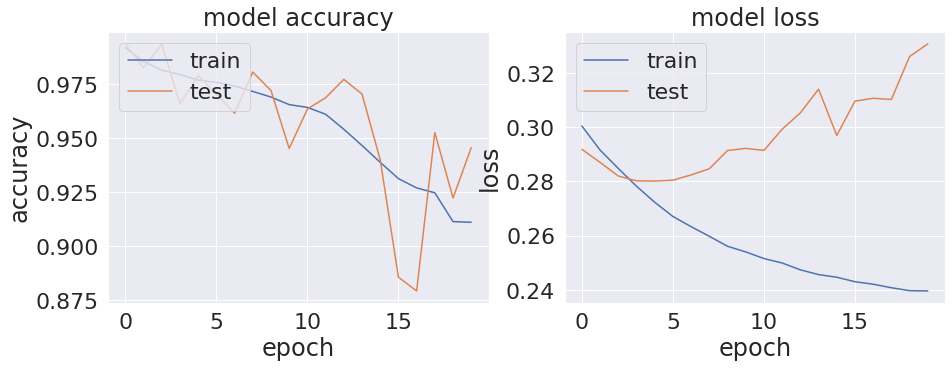

In [ ]:
def plot_metrics(history):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(history.history['acc'])
  ax1.plot(history.history['val_acc'])
  ax1.set(xlabel='epoch', ylabel='accuracy') 
  ax1.set_title('model accuracy')
  ax1.legend(['train','test'], loc = 'upper left')
  #ax1.show()

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])

  ax2.set_title('model loss')
  ax2.set(xlabel='epoch', ylabel='loss') 
  ax2.legend(['train','test'], loc = 'upper left')
  #ax2.show()

plot_metrics(history_model)

In [ ]:
last = Embedding(max_features, embed_size, 
                               mask_zero=False, weights=[embedding_matrix], trainable=False)(input_text)
last.add(SpatialDropout1D(0.4))
last.add(LSTM(units=50,  recurrent_dropout=0.2, return_sequences = True))
last.add(Dropout(0.2))
last.add((LSTM(units=50,  recurrent_dropout=0.2, return_sequences = True)))
last.add(Dropout(0.2))
last.add((LSTM(units=50,  recurrent_dropout=0.2)))
last.add(Dense(units=6, activation="softmax"))

last.compile(optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"])


history_last = last.fit(
    X_train,
    train[classes].values,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.15,
)

plot_metrics(history_last)


score = last.evaluate(X_test, test[classes].values, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


last.save(f"/content/gdrive/My Drive/Colab Notebooks/last_{score[1].round(3)}.h5")

NameError: ignored

In [ ]:
def evaluate_model(model):
  instance = "You are a motherfucking retard, if you ever insult me again I'll break every bone in your useless body."
  instance = tokenizer.texts_to_sequences(instance)

  flat_list = []
  for sublist in instance:
      for item in sublist:
          flat_list.append(item)

  flat_list = [flat_list]

  np.set_printoptions(formatter={"float_kind": "{:f}".format})

  instance = pad_sequences(flat_list, maxlen=maxlen)
  print("\n#####INSULT####\n")
  print(model.predict(instance))


  instance = """
              == Referential Indexicality == \n\n I do not get the explanation about Unicorns drink ambrosia. 
              \n To me, the point of that example would have to have something to do with the fact that Unicorns and Ambrosia don't exist. 
              But that would make it more an example of discussions about truth assessment 
              (is it true or not that Unicorns drink Ambrosia and what's there to be said about it given that both do not exist) then of referential content? 
              \n Anyway in the explanation nothing is said about Unicorns and ambrosia being non-existent while 
              that should be at least commented upon given that it is obvious the case if one uses these concepts in particular.
              """

  instance = tokenizer.texts_to_sequences(instance)

  flat_list = []
  for sublist in instance:
      for item in sublist:
          flat_list.append(item)

  flat_list = [flat_list]

  instance = pad_sequences(flat_list, maxlen=maxlen)

  print("\n#####NORMAL COMMENT####\n")
  print(model.predict(instance))


In [ ]:
evaluate_model(rnn)


#####INSULT####

[[0.089232 0.006104 0.014425 0.002809 0.024063 0.005228]]

#####NORMAL COMMENT####

[[0.662329 0.211891 0.351361 0.045664 0.471593 0.183347]]
